In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from bo_code.BO import BO_round
from bo_code.MTBO import generate_initial_data_mtgp, MTBO_round

from rm_code.crf import resolution_score_2D
from rm_code.retention_model import online_system, offline_system, compute_chromatogram_1D
from rm_code.plot_chromatogram import plot_chromatogram, plot_contour_spectrum,  plot_shifting_2D_gradient

from utils.utils import bo_to_rm_2D, check_pars, seed_everything, best_so_far, ci

from tqdm import tqdm
import pandas as pd

tkwargs = (
    {  # Dictionary containing information about data type and data device
        "dtype": torch.double,
        "device": torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu"),
    }
)
# Writing the dictionary to a DataFrame
df = pd.DataFrame([tkwargs])
# Saving the DataFrame to a CSV file, this will be read by other functions.
df.to_csv('data/tkwargs.csv', index=False)

### Set up a 1D retention model

# Set some default parameters for first dimension
t_0_1D = 4.5 # dead time
t_D_1D = 0.1 # dwell time
N_1D = 1000 # plate number 1D
t_init_1D = 2 # init time

# create dictionary for the above described parameters
settings_1D = {'t_0': t_0_1D, 't_D': t_D_1D, 'N': N_1D, 't_init': t_init_1D}

### Set up a 2D retention model

### Define 2D parameters
# lower bounds of shifting gradients are named "init". upper bounds of shifting gradients aer named "final".
# time points of each shift have to be same in the current setup. Shift starts after the dead time of the first dimension. Shift ends at the end of the 1D program
# each gradient in the second dimension has a dead time, gradient time and modulation time.

N_2D = 5000 # plate number 2D

t_M_2D = 2 #/ 3 # modulation time minutes
t_G_2D = 1.8 #/ 3 # gradient time minutes
t_init_2D = 0.1 #/ 3 # init time minutes
t_D_2D = 0.01 # dwell time in minutes
t_0_2D = 0.01 # dead time in minutes

# create dictionary for the above described parameters
settings_2D = {'t_M': t_M_2D, 't_G': t_G_2D, 't_init': t_init_2D, 't_D': t_D_2D, 't_0': t_0_2D, 'N': N_2D}

# maximum allowed times in first and second dimension
max_T = [100, t_M_2D]

# number of analytes
n_analytes = 80

# Load the retention parameters created in "samplin_retention_paremters.ipynb"
ret_pars = pd.read_csv('data/retention_system.csv').to_dict(orient='list')

# Optimization code

# Set some fixed parameters
t_max = 100 # maximum time
phi_min, phi_max = 0, 1 # maximum phi
fixed_phi_pars_1D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_1D = torch.tensor([[0.], [t_max]]) # at fixed time points

fixed_phi_pars_2D = torch.tensor([[phi_min], [phi_max]]) # fixed phi points
fixed_time_pars_2D = torch.tensor([[0.],[t_0_1D], [t_max]]) # at fixed time points

# We will optimize 12 parameters, 4 parameters (2 gradient turning points) in the first dimension.
# And 8 parameters in the second dimension, two time points, and three phi_init and phi_final point of the shifting gradient.
# Pars vector will look like this: [phi1, phi2, t1, t2, phi_i1, phi_i2, phi_i3, phi_f1, phi_f2, phi_f3, t1_shift, t2_shift]
bounds = torch.stack([
    torch.tensor([phi_min, phi_min, 0.1, 0.2, phi_min, phi_min, phi_min, phi_min, phi_min, phi_min, t_0_1D, t_0_1D]),
    torch.tensor([phi_max, phi_max, t_max-0.2, t_max-0.1, phi_max, phi_max, phi_max, phi_max, phi_max, phi_max, t_max-t_M_2D, t_max-t_M_2D])]
)

# bounds after normalization to [0,1]
norm_bounds = torch.stack([torch.zeros(12), torch.ones(12)])

# We will also need to set some inequality constraints : 1. phi_i1 < phi_f2, 2. phi_i2 < phi_f3,
# 3. t1 < t2, 4. phi1 < phi2,  5. -t1_shift + t2_shift > tM
# Spare representation of BoTorch.
# ([indices of parameters], [coefficients], constant), example: ((torch.tensor([0,1]), torch.tensor([-1., 1.]), 0.0)) -x0 + x1 >= 0
inequality_constraints= [(torch.tensor([0,1]), torch.tensor([-1., 1.]), torch.tensor(0.0)), (torch.tensor([2,3]), torch.tensor([-1., 1.]), torch.tensor(0.1)), (torch.tensor([10,11]), torch.tensor([-1., 1.]), torch.tensor(t_M_2D)), (torch.tensor([4,8]), torch.tensor([-1., 1.]), torch.tensor(0.0)), (torch.tensor([5,9]), torch.tensor([-1., 1.]), torch.tensor(0.0))]

# draw 10 random indices between 0 and n_analytes
remove_indices = np.random.randint(0, n_analytes, 10)
# create dictionary with noise levels
noise = {'tR_1D': 2, 'tR_2D': 0.1, 'W_1D': 0.2, 'W_2D': 0.05}

/home/jimboelrijk/mambaforge/envs/MultiTask2DLC/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Goal of this notebook is to check when and where the 1D retention code gives NaN values.
# plan is to generate a lot 1D programs, and run them all and wait until we catch the bug

# generate parameters for initial experiments
pars_online_init, pars_offline_init = generate_initial_data_mtgp(10, 50, bounds, inequality_constraints)

# Perform initial online experiments
phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(pars_offline_init, fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)


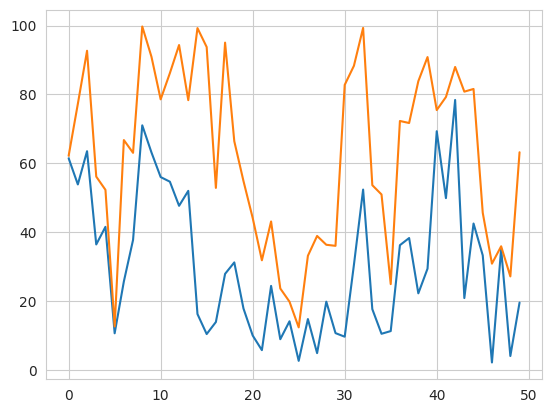

In [5]:
plt.plot(pars_offline_init[:100, 2:4])

In [6]:
for i in tqdm(range(len(pars_offline_init))):
    # compute retention times and widths
    tR_list_1D, W_list_1D = compute_chromatogram_1D(ret_pars, settings_1D, phi_list_1D[i], t_list_1D[i])

    if np.isnan(tR_list_1D).sum() > 0:
        print(settings_1D, phi_list_1D, t_list_1D)
        print(tR_list_1D)
        breakpoint()

    # now we need to add the pars and scores to offline_mt
    # scores_offline_mt.append(res_score - 0.1*time_score)
    # pars_offline_mt.append(pars_offline_init[i])

    #print(res_score)
print('Done with initial random experiments')

100%|██████████| 50/50 [00:02<00:00, 24.96it/s]

Done with initial random experiments


In [64]:
test = torch.tensor([phi_min, 1, 2, 99, phi_min, phi_min, phi_min, phi_min, phi_min, phi_min, t_0_1D, t_0_1D])

phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(test.unsqueeze(0), fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

for i in tqdm(range(len(test.unsqueeze(0)))):
    # compute retention times and widths
    tR_list_1D, W_list_1D = compute_chromatogram_1D(ret_pars, settings_1D, phi_list_1D[i], t_list_1D[i])
    print(phi_list_1D, t_list_1D)
    if np.isnan(tR_list_1D).sum() > 0:
        #print(settings_1D, phi_list_1D, t_list_1D)
        print('here')
        print(tR_list_1D)
        break

    # now we need to add the pars and scores to offline_mt
    # scores_offline_mt.append(res_score - 0.1*time_score)
    # pars_offline_mt.append(pars_offline_init[i])

    #print(res_score)
print('Done with initial random experiments')

100%|██████████| 1/1 [00:00<00:00, 27.45it/s]

tensor([[0., 0., 1., 1.]], dtype=torch.float64) tensor([[  0.,   2.,  99., 100.]], dtype=torch.float64)
Done with initial random experiments


In [67]:
phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(bounds[1].unsqueeze(0), fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

for i in tqdm(range(len(bounds[1].unsqueeze(0)))):
    # compute retention times and widths
    tR_list_1D, W_list_1D = compute_chromatogram_1D(ret_pars, settings_1D, phi_list_1D[i], t_list_1D[i])
    print(phi_list_1D, t_list_1D)

    if np.isnan(tR_list_1D).sum() > 0:
        print(settings_1D, phi_list_1D, t_list_1D)
        print(tR_list_1D)
        print('here')
        breakpoint()

    # now we need to add the pars and scores to offline_mt
    # scores_offline_mt.append(res_score - 0.1*time_score)
    # pars_offline_mt.append(pars_offline_init[i])

    #print(res_score)
print('Done with initial random experiments')

100%|██████████| 1/1 [00:00<00:00, 25.20it/s]

tensor([[0., 1., 1., 1.]], dtype=torch.float64) tensor([[  0.0000,  99.8000,  99.9000, 100.0000]], dtype=torch.float64)
Done with initial random experiments


In [72]:
phi_list_1D, t_list_1D, phi_init_2D, phi_final_2D, t_list_2D = bo_to_rm_2D(bounds[0].unsqueeze(0), fixed_phi_pars_1D, fixed_time_pars_1D, fixed_phi_pars_2D, fixed_time_pars_2D)

for i in tqdm(range(len(bounds[0].unsqueeze(0)))):
    # compute retention times and widths
    tR_list_1D, W_list_1D = compute_chromatogram_1D(ret_pars, settings_1D, phi_list_1D[i], t_list_1D[i])
    print(phi_list_1D, t_list_1D)

    if np.isnan(tR_list_1D).sum() > 0:
        print(settings_1D, phi_list_1D, t_list_1D)
        print('here')
        breakpoint()

    print(tR_list_1D)

    # now we need to add the pars and scores to offline_mt
    # scores_offline_mt.append(res_score - 0.1*time_score)
    # pars_offline_mt.append(pars_offline_init[i])

    #print(res_score)
print('Done with initial random experiments')

100%|██████████| 1/1 [00:00<00:00, 17.12it/s]

tensor([[0., 0., 0., 1.]], dtype=torch.float64) tensor([[  0.0000,   0.1000,   0.2000, 100.0000]], dtype=torch.float64)
[ 37.92987247  34.87930388  33.30310967  40.36540818  42.31000593
  45.43191686  44.40273619  35.76597535  38.6173694   35.01789487
  49.65414156  35.9603763   37.89437822  45.76247656  44.5975847
  46.38313973  38.38985848  36.97167439  36.3554647   40.96162432
  37.53354422  42.68774952  44.16323667  40.21059217  38.49018642
  36.65646062  40.40179865  40.94585164  35.04530307  49.22464553
  39.67428668  41.47167353  40.43337859  36.30756309  35.72437207
  37.30825318  43.68294602  41.00833891  36.57409719  37.10216692
  93.18323667  83.73739469  80.38678754  98.46198224 105.11384772
 114.31904596 111.4342379   86.1715006   94.08283785  84.74631521
 136.85297764  86.39292337  91.58385504 115.20563275 111.28018995
 117.90575179  94.62414596  90.22548078  89.02133038 101.11387497
  91.33747491 106.14158382 109.33678792  98.92115825  94.27086833
  88.61963514 100.12800